In [8]:
#Basic imports
%matplotlib inline
import importlib 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from numba import cuda
import warnings

# Data Processing

In [9]:
# Import data
df = pd.read_excel('data.xlsx', 'Timepoint 1', header=1)
data = pd.read_excel('data2.xlsx', 'Sheet1', header=0)

In [10]:
data['Date of birth'] = pd.to_datetime(data['Date of birth'].astype(str), format='%d/%m/%Y')
data['Date of MRI scan'] = pd.to_datetime(data['Date of MRI scan'].astype(str), format='%Y-%m-%d', errors='ignore')
data['Age'] = (data['Date of MRI scan'] - data['Date of birth'])/ np.timedelta64(1, 'Y')

In [11]:
def clean_data(df, del_col=[], mean=[], std=[]):
    X = df.copy()
    
    # Remove useless columns
    #X = X.drop(['Subject ID', 'Date of birth', 'Date of MRI scan'], axis=1)
    #X = X.drop(['Patient ID', 'Batch Process ID'], axis=1)
    
    # Remove columns with only zeros
    if (len(del_col) == 0):
        del_col = (X != 0).any(axis=0)
    X = X.loc[:, del_col]
    
    # Replace zeros by nan
    X.replace(0, np.nan, inplace=True)
    
    # Replace Sex labels by values
    #X['Sex'].replace({'Male':1,'Female':2}, inplace=True)
    
    # Categorical values
    cater = X[['Gender']]
    #cater = X[['Sex']]
    
    # Numerical values
    numer = X.drop(['Gender'], axis=1)
    #numer = X.drop(['Sex'], axis=1)
    
    # Replace nan values by mean of column
    if (len(mean) == 0 or len(std) == 0):
        mean = numer.mean()
        std = numer.std()
        std = std.fillna( 1)
    numer = numer.fillna(mean)
                 
    
    #Scale each column in numer
    numer = (numer - mean)/std
    
    new_X = pd.concat([numer, cater], axis=1, join='inner')
    
    return new_X, del_col, mean, std

In [12]:
#Select features that are apparently correlated with age (according to paper)
df = df[['Sex','[norm] Middle frontal gyrus right volume','[norm] Middle frontal gyrus left volume','[norm] Superior frontal gyrus medial segment right volume','[norm] Superior frontal gyrus medial segment left volume','[norm] Opercular part of the inferior frontal gyrus right volume','[norm] Opercular part of the inferior frontal gyrus left volume','[norm] Triangular part of the inferior frontal gyrus right volume','[norm] Triangular part of the inferior frontal gyrus left volume','[norm] Superior temporal gyrus right volume','[norm] Superior temporal gyrus left volume', '[norm] Middle temporal gyrus right volume', '[norm] Middle temporal gyrus left volume','[norm] Precuneus right volume','[norm] Precuneus left volume','[norm] Thalamus proper right volume','[norm] Thalamus proper left volume','[norm] Caudate right volume','[norm] Caudate left volume','[norm] Amygdala right volume','[norm] Amygdala left volume','[norm] Hippocampus right volume','[norm] Hippocampus left volume','[norm] Putamen right volume','[norm] Putamen left volume','[norm] Pallidum right volume','[norm] Pallidum left volume','[norm] Accumbens area right volume','[norm] Accumbens area left volume', 'Age']]
data = data[['Gender','Left Middle frontal gyrus','Right Middle frontal gyrus', 'Left Inferior frontal gyrus-opercular part', 'Right Inferior frontal gyrus-opercular part','Left Inferior frontal gyrus-triangular part','Right Inferior frontal gyrus-triangular part','Left Superior frontal gyrus-medial','Right Superior frontal gyrus-medial','Left Superior temporal gyrus','Right Superior temporal gyrus','Left Middle temporal gyrus','Right Middle temporal gyrus','Left Precuneus','Right Precuneus','Left Thalamus','Right Thalamus','Left Caudate nucleus','Right Caudate nucleus','Left Amygdala','Right Amygdala','Left Hippocampus','Right Hippocampus','Left Lenticular nucleus-Putamen','Right Lenticular nucleus-Putamen','Left Lenticular nucleus-Pallidum','Right Lenticular nucleus-Pallidum','Left Nucleus accumbens','Right Nucleus accumbens', 'Age']]


# Train models on data set 2:

In [13]:
data_train, data_test, y_train, y_test = train_test_split(data.drop(['Age'], axis=1), data['Age'], test_size=0.3, random_state=2)

In [14]:
x_train, del_col, mean_train, std_train = clean_data(data_train)
x_test, _, _, _ = clean_data(data_test, del_col, mean_train, std_train)

In [15]:
def predict(model, x_train, x_test):
    predict_train = model.predict(x_train)
    predict_test = model.predict(x_test)
    
    return predict_train, predict_test

In [16]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [17]:
def compute_mae(y_train, y_test, predict_train, predict_test):
    train_mae = mean_absolute_error(y_train, predict_train)
    test_mae = mean_absolute_error(y_test, predict_test)
    
    return train_mae, test_mae

In [18]:
def compute_r2(y_train, y_test, predict_train, predict_test):
    train_r2 = r2_score(y_train, predict_train)
    test_r2 = r2_score(y_test, predict_test)
    
    return train_r2, test_r2

In [19]:
def plot_results(x_train, x_test, predict_train, predict_test):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_xlabel('True Age', fontsize = 15)
    ax1.set_ylabel('Predicted Age', fontsize = 15)
    ax1.set_title('Train', fontsize = 20)
    ax2.set_xlabel('True Age', fontsize = 15)
    ax2.set_ylabel('Predicted Age', fontsize = 15)
    ax2.set_title('Test', fontsize = 20)

    targets = [0, 1, 2]
    colors = ['r', 'g', 'b']
    for target, color in zip(targets, colors):
        idx_train = (x_train['Cluster'] == target).to_numpy()
        idx_test = (x_test['Cluster'] == target).to_numpy()
        ax1.scatter(y_train[idx_train],
                    predict_train[idx_train],
                   c = color, 
                   s = 50)
        ax2.scatter(y_test[idx_test],
                    predict_test[idx_test],
                   c = color, 
                   s = 50)
    ax1.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
    ax1.grid()
    ax2.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
    ax2.grid()

    p1 = max(max(predict_train), max(np.array(y_train)))
    p2 = min(min(predict_train), min(np.array(y_train)))
    ax1.plot([p1, p2], [p1, p2], 'b-')
    ax2.plot([p1, p2], [p1, p2], 'b-')

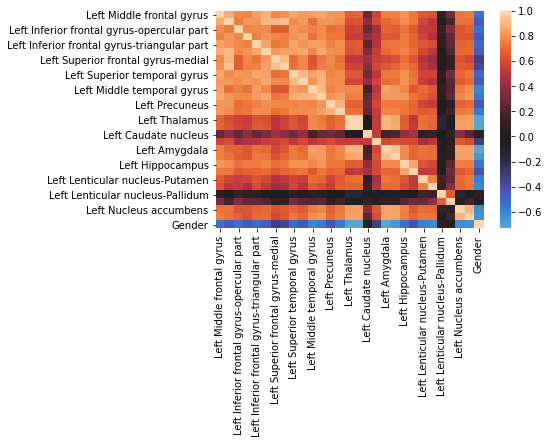

In [20]:
sns.heatmap(x_train.corr(), center=0);

# PLS

In [21]:
from sklearn.cross_decomposition import PLSRegression

In [22]:
# PLS Regression
n_components = 20
pls = PLSRegression(n_components=n_components)
pls.fit(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'), y_train)

new_x_train = pls.transform(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
new_x_test = pls.transform(x_test.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pls_train = pd.DataFrame(data = new_x_train, columns = ["class%02d" %i for i in range(1,n_components+1)])
pls_test = pd.DataFrame(data = new_x_test, columns = ["class%02d" %i for i in range(1,n_components+1)])

### Standardize

In [23]:
train_mean = np.mean(pls_train, axis=0)
train_std = np.std(pls_test, axis=0)

pls_train_scaled = (pls_train - train_mean)/train_std
pls_test_scaled = (pls_test - train_mean)/train_std

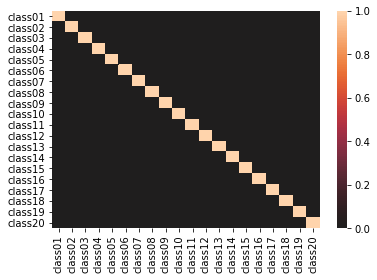

In [24]:
sns.heatmap(pd.DataFrame(pls_train_scaled).corr(), center=0);

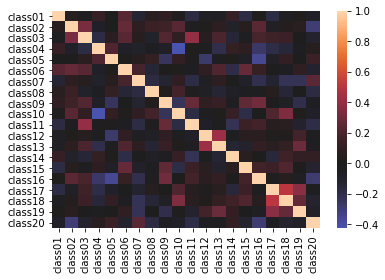

In [25]:
sns.heatmap(pd.DataFrame(pls_test_scaled).corr(), center=0);

### Clustering

In [26]:
kmeanModel = KMeans(n_clusters=3).fit(pls_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

pls_train_scaled['Cluster'] = kmeanModel.labels_
pls_test_scaled['Cluster'] = kmeanModel.predict(pls_test_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

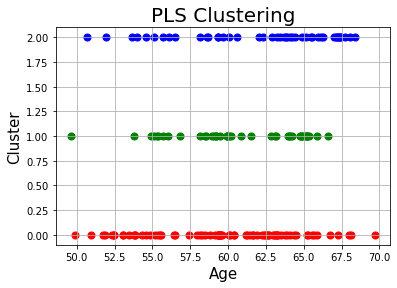

In [37]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Age', fontsize = 15)
ax.set_ylabel('Cluster', fontsize = 15)
ax.set_title('PLS Clustering', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    idx = (pls_train_scaled['Cluster'] == target).to_numpy()
    ax.scatter(y_train[idx],
            np.full(y_train[idx].shape, target),
               c = color, 
               s = 50)
ax.grid()
plt.savefig('PLS_clustering_data1.png')

### Filter MI Score

In [28]:
mi_score_train = make_mi_scores(pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

keep_pls = (mi_score_train[mi_score_train > 0].index.to_list())

keep_pls.append('Cluster')

pls_train_scaled = pls_train_scaled[keep_pls]
pls_test_scaled = pls_test_scaled[keep_pls]

### SVR

Fitting 15 folds for each of 210 candidates, totalling 3150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1745s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0450s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0570s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:  

Best r2: 0.057
Train r2: 0.363
Test r2: 0.206
Train MAE: 2.038
Test MAE: 2.525

Best params:
 {'clf__C': 10.0, 'clf__gamma': 0.007847599703514606, 'clf__kernel': 'rbf'}


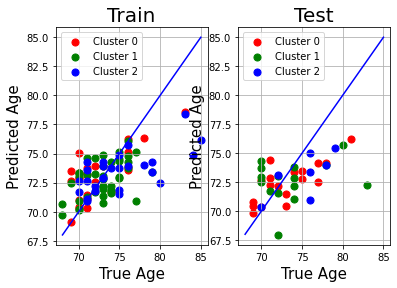

In [28]:
from sklearn import svm

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_svm = Pipeline([
            ('clf', svm.SVR())
])
# Set grid search params
param_grid_svm = [
  {'clf__C': np.logspace(-3, 3, 10), 'clf__kernel': ['linear']},
  {'clf__C': np.logspace(-3, 3, 10), 'clf__gamma': np.logspace(-10, 0, 20), 'clf__kernel': ['rbf']},
 ]
# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='r2',
            cv=cv, verbose=10, n_jobs=-1, return_train_score = True)
# Fit using grid search
gs_svm.fit(pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_svm.best_estimator_,
    pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'),
    pls_test_scaled.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_svm.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

plot_results(pls_train_scaled, pls_test_scaled, predict_train, predict_test)

### Elastic Net

Fitting 15 folds for each of 525 candidates, totalling 7875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0280s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0540s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0700s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1450s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 768 t

Best r2: 0.075
Train r2: 0.359
Test r2: 0.268
Train MAE: 2.111
Test MAE: 2.348

Best params:
 {'clf__alpha': 0.16155980984398763, 'clf__l1_ratio': 1.0}


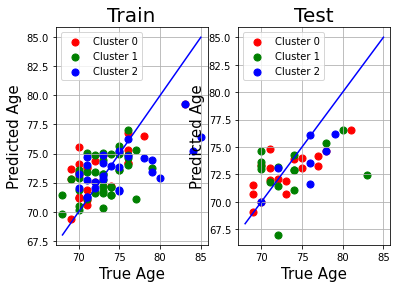

In [29]:
from sklearn.linear_model import ElasticNet

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_el = Pipeline([
            ('clf', ElasticNet())
])
# Set grid search params
elastic_param_grid = {
    'clf__alpha': np.logspace(-10,7,25),
    'clf__l1_ratio': np.append(np.logspace(-10,0,20), 0)
}

# Construct grid search
gs_el = GridSearchCV(estimator=pipe_el,
            param_grid=elastic_param_grid,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_el.fit(pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_el.best_estimator_,
    pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'),
    pls_test_scaled.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_el.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_el.best_params_)

plot_results(pls_train_scaled, pls_test_scaled, predict_train, predict_test)

### Adaboost

Fitting 15 folds for each of 30 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1486s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1435s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0521s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  

Best r2: -0.059
Train r2: 0.656
Test r2: 0.229
Train MAE: 1.560
Test MAE: 2.517

Best params:
 {'clf__learning_rate': 0.1, 'clf__n_estimators': 21}


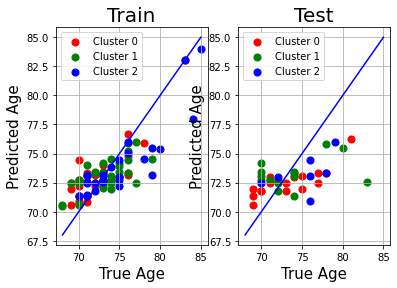

In [30]:
from sklearn.ensemble import AdaBoostRegressor

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_ab = Pipeline([
            ('clf', AdaBoostRegressor(random_state = 123))
])
# Set grid search params
adaboost_param_grid = {
    'clf__n_estimators': np.arange(1, 200, 20),
    'clf__learning_rate': [1.0, 0.5, 0.1]
}

# Construct grid search
gs_ab = GridSearchCV(estimator=pipe_ab,
            param_grid=adaboost_param_grid,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_ab.fit(pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_ab.best_estimator_,
    pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'),
    pls_test_scaled.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_ab.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_ab.best_params_)

plot_results(pls_train_scaled, pls_test_scaled, predict_train, predict_test)

### Random Forest

Fitting 15 folds for each of 95 candidates, totalling 1425 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0430s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 314 tas

Best r2: -0.036
Train r2: 0.638
Test r2: 0.200
Train MAE: 1.630
Test MAE: 2.511

Best params:
 {'clf__max_depth': 3, 'clf__n_estimators': 50}


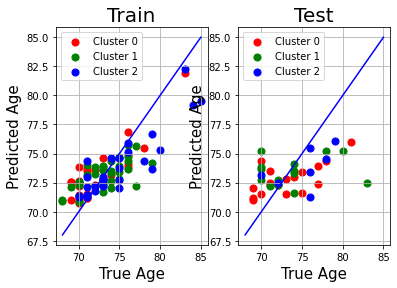

In [31]:
# Long time to run !!


# imports
from sklearn.ensemble import RandomForestRegressor

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_rf = Pipeline([
            ('clf', RandomForestRegressor())
])
# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': np.arange(10, 100, 20),
   'clf__max_depth': np.arange(1, 20)
  }
]
# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_rf.fit(pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_rf.best_estimator_,
    pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'),
    pls_test_scaled.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_rf.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

plot_results(pls_train_scaled, pls_test_scaled, predict_train, predict_test)

### KNN

Fitting 15 folds for each of 19 candidates, totalling 285 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1938s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0487s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0752s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1447s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 270 o

Best r2: -0.020
Train r2: 0.278
Test r2: 0.204
Train MAE: 2.280
Test MAE: 2.556

Best params:
 {'clf__n_neighbors': 13}


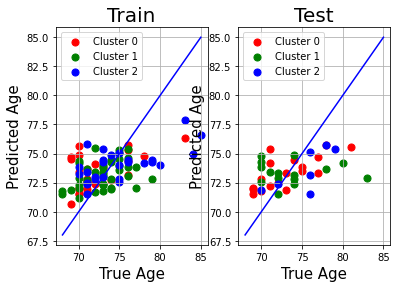

In [32]:
# imports
from sklearn.neighbors import KNeighborsRegressor

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_knn = Pipeline([
            ('clf', KNeighborsRegressor())
])
# Set grid search params
param_grid_knn = [ 
  {
      'clf__n_neighbors': np.arange(1, 20)
  }
]
# Construct grid search
gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=param_grid_knn,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_knn.fit(pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_knn.best_estimator_,
    pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'),
    pls_test_scaled.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_knn.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_knn.best_params_)

plot_results(pls_train_scaled, pls_test_scaled, predict_train, predict_test)

# PCA

In [29]:
from sklearn.decomposition import PCA

<ipython-input-38-f7bd4eb0def8>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


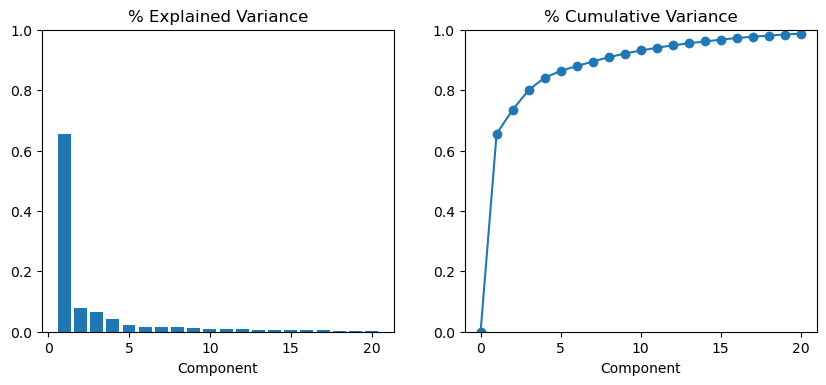

In [38]:
pca = PCA(n_components=20)
pc = pca.fit_transform(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pc_train = pd.DataFrame(data = pc, columns = ["PC%02d" %i for i in range(1,pca.n_components_+1)])
pc_test = pca.transform(x_test.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pc_test = pd.DataFrame(data = pc_test, columns = ["PC%02d" %i for i in range(1,pca.n_components_+1)])

# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

# Explained variance
evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title=f"% Explained Variance", ylim=(0.0, 1.0)
)

# Cumulative Variance
cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].set(
    xlabel="Component", title=f"% Cumulative Variance", ylim=(0.0, 1.0)
)

# Set up figure
fig.set(figwidth=10, dpi=100)
fig.show()
plt.savefig('explained_var_PCA_data1.png')

### Standardize

In [31]:
train_mean = np.mean(pc_train, axis=0)
train_std = np.std(pc_train, axis=0)

pc_train_scaled = (pc_train - train_mean)/train_std
pc_test_scaled = (pc_test - train_mean)/train_std

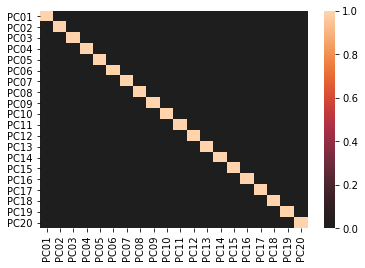

In [32]:
sns.heatmap(pd.DataFrame(pc_train_scaled).corr(), center=0);

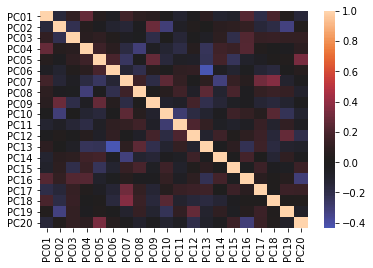

In [33]:
sns.heatmap(pd.DataFrame(pc_test_scaled).corr(), center=0);

### Clustering

In [34]:
kmeanModel = KMeans(n_clusters=3).fit(pc_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

pc_train_scaled['Cluster'] = kmeanModel.labels_
pc_test_scaled['Cluster'] = kmeanModel.predict(pc_test_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

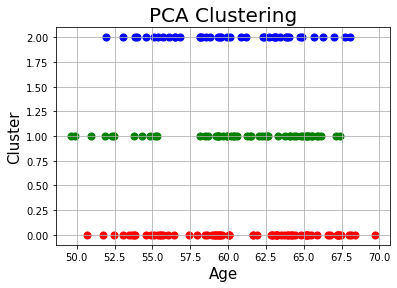

In [39]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Age', fontsize = 15)
ax.set_ylabel('Cluster', fontsize = 15)
ax.set_title('PCA Clustering', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    idx = (pc_train_scaled['Cluster'] == target).to_numpy()
    ax.scatter(y_train[idx],
            np.full(y_train[idx].shape, target),
               c = color, 
               s = 50)
ax.grid()
plt.savefig('PCA_clustering_data1.png')

### Filter MI Score

After testing, keeping only PC with MI Score > 0 didn't improve the results (slightly worse in fact)

### Random Forest

Fitting 15 folds for each of 95 candidates, totalling 1425 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1090s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 314 tas

Best r2: -0.100
Train r2: 0.311
Test r2: -0.026
Train MAE: 2.222
Test MAE: 2.805

Best params:
 {'clf__max_depth': 1, 'clf__n_estimators': 30}


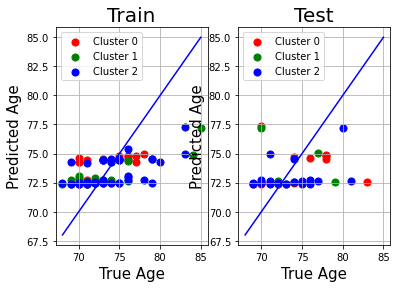

In [40]:
# Long time to run !!


# imports
from sklearn.ensemble import RandomForestRegressor

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_rf = Pipeline([
            ('clf', RandomForestRegressor())
])
# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': np.arange(10, 100, 20),
   'clf__max_depth': np.arange(1, 20)
  }
]
# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_rf.fit(pc_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_rf.best_estimator_,
    pc_train_scaled.drop(['Cluster'], axis=1, errors='ignore'),
    pc_test_scaled.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_rf.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

plot_results(pc_train_scaled, pc_test_scaled, predict_train, predict_test)

### AdaBoost

Fitting 15 folds for each of 30 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Best r2: -0.008
Train r2: 0.611
Test r2: 0.180
Train MAE: 2.490
Test MAE: 3.872

Best params:
 {'clf__learning_rate': 0.1, 'clf__n_estimators': 81}


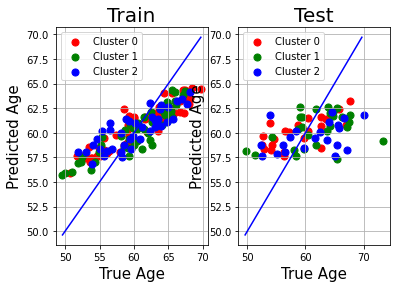

In [36]:
from sklearn.ensemble import AdaBoostRegressor

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_ab = Pipeline([
            ('clf', AdaBoostRegressor(random_state = 123))
])
# Set grid search params
adaboost_param_grid = {
    'clf__n_estimators': np.arange(1, 200, 20),
    'clf__learning_rate': [1.0, 0.5, 0.1]
}

# Construct grid search
gs_ab = GridSearchCV(estimator=pipe_ab,
            param_grid=adaboost_param_grid,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_ab.fit(pc_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_ab.best_estimator_,
    pc_train_scaled.drop(['Cluster'], axis=1, errors='ignore'),
    pc_test_scaled.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_ab.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_ab.best_params_)

plot_results(pc_train_scaled, pc_test_scaled, predict_train, predict_test)

### SVR

Fitting 15 folds for each of 210 candidates, totalling 3150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0251s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0560s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0714s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  

Best r2: -0.045
Train r2: 0.296
Test r2: 0.145
Train MAE: 2.064
Test MAE: 2.575

Best params:
 {'clf__C': 1000.0, 'clf__gamma': 1.8329807108324338e-05, 'clf__kernel': 'rbf'}


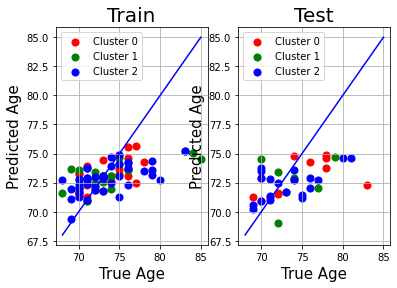

In [42]:
from sklearn import svm

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_svm = Pipeline([
            ('clf', svm.SVR())
])
# Set grid search params
param_grid_svm = [
  {'clf__C': np.logspace(-3, 3, 10), 'clf__kernel': ['linear']},
  {'clf__C': np.logspace(-3, 3, 10), 'clf__gamma': np.logspace(-10, 0, 20), 'clf__kernel': ['rbf']},
 ]
# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='r2',
            cv=cv, verbose=10,n_jobs=-1, return_train_score = True)
# Fit using grid search
gs_svm.fit(pc_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_svm.best_estimator_,
    pc_train_scaled.drop(['Cluster'], axis=1, errors='ignore'),
    pc_test_scaled.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_svm.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

plot_results(pc_train_scaled, pc_test_scaled, predict_train, predict_test)

### Elastic Net

Fitting 15 folds for each of 525 candidates, totalling 7875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0305s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0650s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0852s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1900s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 768 t

Best r2: -0.054
Train r2: 0.295
Test r2: 0.205
Train MAE: 2.202
Test MAE: 2.520

Best params:
 {'clf__alpha': 0.8254041852680207, 'clf__l1_ratio': 0.2976351441631313}


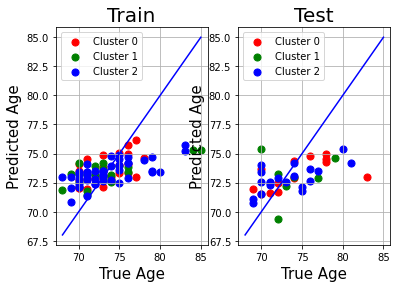

In [43]:
from sklearn.linear_model import ElasticNet

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_el = Pipeline([
            ('clf', ElasticNet())
])
# Set grid search params
elastic_param_grid = {
    'clf__alpha': np.logspace(-10,7,25),
    'clf__l1_ratio': np.append(np.logspace(-10,0,20), 0)
}

# Construct grid search
gs_el = GridSearchCV(estimator=pipe_el,
            param_grid=elastic_param_grid,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_el.fit(pc_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_el.best_estimator_,
    pc_train_scaled.drop(['Cluster'], axis=1, errors='ignore'),
    pc_test_scaled.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_el.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_el.best_params_)

plot_results(pc_train_scaled, pc_test_scaled, predict_train, predict_test)

### KNN

Fitting 15 folds for each of 19 candidates, totalling 285 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0160s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0580s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0711s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1285s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 245 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 285 o

Best r2: -0.132
Train r2: 0.128
Test r2: 0.117
Train MAE: 2.498
Test MAE: 2.656

Best params:
 {'clf__n_neighbors': 18}


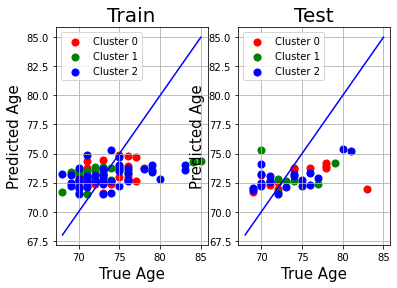

In [44]:
# imports
from sklearn.neighbors import KNeighborsRegressor

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_knn = Pipeline([
            ('clf', KNeighborsRegressor())
])
# Set grid search params
param_grid_knn = [ 
  {
      'clf__n_neighbors': np.arange(1, 20)
  }
]
# Construct grid search
gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=param_grid_knn,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_knn.fit(pc_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_knn.best_estimator_,
    pc_train_scaled.drop(['Cluster'], axis=1, errors='ignore'),
    pc_test_scaled.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_knn.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_knn.best_params_)

plot_results(pc_train_scaled, pc_test_scaled, predict_train, predict_test)

### Raw data

### Clustering

In [45]:
kmeanModel = KMeans(n_clusters=3).fit(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

x_train['Cluster'] = kmeanModel.labels_
x_test['Cluster'] = kmeanModel.predict(x_test.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

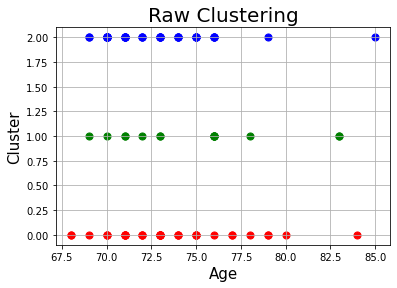

In [46]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Age', fontsize = 15)
ax.set_ylabel('Cluster', fontsize = 15)
ax.set_title('Raw Clustering', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    idx = (x_train['Cluster'] == target).to_numpy()
    ax.scatter(y_train[idx],
            np.full(y_train[idx].shape, target),
               c = color, 
               s = 50)
ax.grid()

### Elastic Net

Fitting 15 folds for each of 525 candidates, totalling 7875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0320s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0600s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0932s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  

Best r2: -0.095
Train r2: 0.242
Test r2: 0.196
Train MAE: 2.351
Test MAE: 2.614

Best params:
 {'clf__alpha': 0.8254041852680207, 'clf__l1_ratio': 0.2976351441631313}


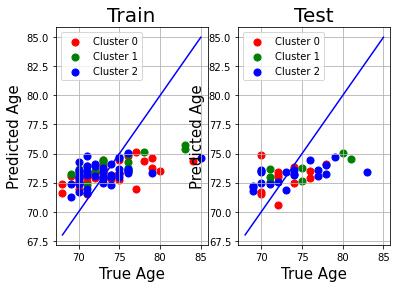

In [47]:
from sklearn.linear_model import ElasticNet

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_el = Pipeline([
            ('clf', ElasticNet())
])
# Set grid search params
elastic_param_grid = {
    'clf__alpha': np.logspace(-10,7,25),
    'clf__l1_ratio': np.append(np.logspace(-10,0,20), 0)
}

# Construct grid search
gs_el = GridSearchCV(estimator=pipe_el,
            param_grid=elastic_param_grid,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_el.fit(x_train.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_el.best_estimator_,
    x_train.drop(['Cluster'], axis=1, errors='ignore'),
    x_test.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_el.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_el.best_params_)

plot_results(x_train, x_test, predict_train, predict_test)

### SVR

Fitting 15 folds for each of 210 candidates, totalling 3150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0242s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0510s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0623s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  

Best r2: -0.107
Train r2: 0.255
Test r2: 0.044
Train MAE: 2.065
Test MAE: 2.713

Best params:
 {'clf__C': 1000.0, 'clf__gamma': 1.8329807108324338e-05, 'clf__kernel': 'rbf'}


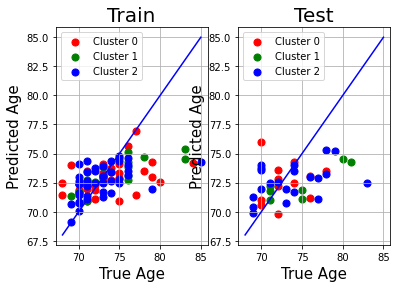

In [48]:
from sklearn import svm

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_svm = Pipeline([
            ('clf', svm.SVR())
])
# Set grid search params
param_grid_svm = [
  {'clf__C': np.logspace(-3, 3, 10), 'clf__kernel': ['linear']},
  {'clf__C': np.logspace(-3, 3, 10), 'clf__gamma': np.logspace(-10, 0, 20), 'clf__kernel': ['rbf']},
 ]
# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='r2',
            cv=cv, verbose=10,n_jobs=-1, return_train_score = True)
# Fit using grid search
gs_svm.fit(x_train.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_svm.best_estimator_,
    x_train.drop(['Cluster'], axis=1, errors='ignore'),
    x_test.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_svm.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

plot_results(x_train, x_test, predict_train, predict_test)

### Random Forest

Fitting 15 folds for each of 95 candidates, totalling 1425 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0557s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 314 tas

Best r2: -0.233
Train r2: 0.232
Test r2: 0.087
Train MAE: 2.406
Test MAE: 2.767

Best params:
 {'clf__max_depth': 1, 'clf__n_estimators': 90}


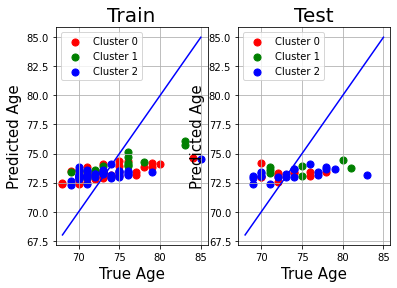

In [49]:
# Long time to run !!


# imports
from sklearn.ensemble import RandomForestRegressor

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_rf = Pipeline([
            ('clf', RandomForestRegressor())
])
# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': np.arange(10, 100, 20),
   'clf__max_depth': np.arange(1, 20)
  }
]
# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_rf.fit(x_train.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_rf.best_estimator_,
    x_train.drop(['Cluster'], axis=1, errors='ignore'),
    x_test.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_rf.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

plot_results(x_train, x_test, predict_train, predict_test)

### Adaboost

Fitting 15 folds for each of 30 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0255s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1657s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0673s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  

Best r2: -0.177
Train r2: 0.770
Test r2: 0.141
Train MAE: 1.420
Test MAE: 2.578

Best params:
 {'clf__learning_rate': 0.1, 'clf__n_estimators': 101}


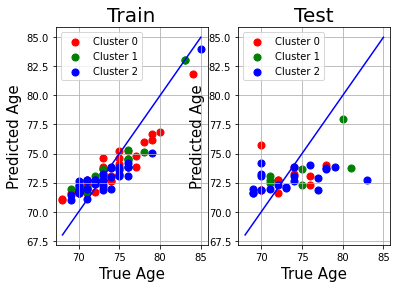

In [50]:
from sklearn.ensemble import AdaBoostRegressor

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_ab = Pipeline([
            ('clf', AdaBoostRegressor(random_state = 123))
])
# Set grid search params
adaboost_param_grid = {
    'clf__n_estimators': np.arange(1, 200, 20),
    'clf__learning_rate': [1.0, 0.5, 0.1]
}

# Construct grid search
gs_ab = GridSearchCV(estimator=pipe_ab,
            param_grid=adaboost_param_grid,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_ab.fit(x_train.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_ab.best_estimator_,
    x_train.drop(['Cluster'], axis=1, errors='ignore'),
    x_test.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_ab.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_ab.best_params_)

plot_results(x_train, x_test, predict_train, predict_test)

### KNN

Fitting 15 folds for each of 19 candidates, totalling 285 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0240s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0470s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0766s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1692s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 231 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 285 o

Best r2: -0.215
Train r2: 0.065
Test r2: 0.086
Train MAE: 2.606
Test MAE: 2.718

Best params:
 {'clf__n_neighbors': 19}


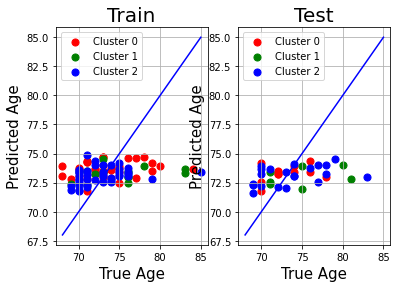

In [51]:
# imports
from sklearn.neighbors import KNeighborsRegressor

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_knn = Pipeline([
            ('clf', KNeighborsRegressor())
])
# Set grid search params
param_grid_knn = [ 
  {
      'clf__n_neighbors': np.arange(1, 20)
  }
]
# Construct grid search
gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=param_grid_knn,
            scoring='r2',
            n_jobs=-1,
            cv=cv, verbose=10, return_train_score = True)

# Fit using grid search
gs_knn.fit(x_train.drop(['Cluster'], axis=1, errors='ignore'), y_train)

# Compute predictions
predict_train, predict_test = predict(
    gs_knn.best_estimator_,
    x_train.drop(['Cluster'], axis=1, errors='ignore'),
    x_test.drop(['Cluster'], axis=1, errors='ignore')
)
    
# Compute MAE and R2 scores
train_mae, test_mae = compute_mae(y_train, y_test, predict_train, predict_test)
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)

# Best scores
print('Best r2: %.3f' % gs_knn.best_score_)
print('Train r2: %.3f' % train_r2)
print('Test r2: %.3f' % test_r2)
print('Train MAE: %.3f' % train_mae)
print('Test MAE: %.3f' % test_mae)

# Best params
print('\nBest params:\n', gs_knn.best_params_)

plot_results(x_train, x_test, predict_train, predict_test)